# Table of Contents
 <p><div class="lev2 toc-item"><a href="#load-nr-data" data-toc-modified-id="load-nr-data-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>load nr data</a></div><div class="lev3 toc-item"><a href="#minimise-over-a-phase-shift" data-toc-modified-id="minimise-over-a-phase-shift-011"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>minimise over a phase shift</a></div><div class="lev3 toc-item"><a href="#try-computing-the-match" data-toc-modified-id="try-computing-the-match-012"><span class="toc-item-num">0.1.2&nbsp;&nbsp;</span>try computing the match</a></div><div class="lev3 toc-item"><a href="#plot-model-and-data" data-toc-modified-id="plot-model-and-data-013"><span class="toc-item-num">0.1.3&nbsp;&nbsp;</span>plot model and data</a></div><div class="lev3 toc-item"><a href="#testing-set" data-toc-modified-id="testing-set-014"><span class="toc-item-num">0.1.4&nbsp;&nbsp;</span>testing set</a></div>

In [594]:
import phenom

In [595]:
from phenom import eta_from_q, q_from_eta

import numpy as np
import matplotlib.pyplot as plt

from keras.models import model_from_json

In [596]:
from waveform import SingleModeNRWaveform

In [597]:
# load json and create model
json_file = open('model-softplus-amp.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_amp = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_amp.load_weights("model-softplus-amp.h5")
print("Loaded amp model from disk")

Loaded amp model from disk


In [598]:
# load json and create model
json_file = open('model-softplus-phi.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_phi = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_phi.load_weights("model-softplus-phi.h5")
print("Loaded phi model from disk")

Loaded phi model from disk


In [599]:
loaded_model_amp.compile(loss='mean_squared_error', optimizer='adam')

In [600]:
loaded_model_phi.compile(loss='mean_squared_error', optimizer='adam')

In [601]:
def predict_h22(amp_nn, phi_nn, q, times, scale_value=600):
    qlist = np.zeros(len(times)) + q
    
    X = np.column_stack((times, qlist))
    
    amp = amp_nn.predict(X)
    phi = phi_nn.predict(X)
    phi *= scale_value
    
    return amp, phi

## load nr data

In [602]:
# nrfiles = [
#     '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
#     '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
#     '/Users/sebastian/work/data/SXS_BBH_0168_Res5.h5', #q=3
#     '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5' #q=4
# ]

In [603]:
nrfiles = [
    '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
    '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/sebastian/work/data/SXS_BBH_0168_Res5.h5', #q=3
    '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5', #q=4
    '/Users/sebastian/work/data/SXS_BBH_0259_Res5.h5', #q=2.5
    '/Users/sebastian/work/data/SXS_BBH_0107_Res5.h5', #5
    '/Users/sebastian/work/data/SXS_BBH_0063_Res5.h5', #8
    '/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5' #10
]

In [604]:
ell = 2
mm = 2

npts_time = 1000*5
npts_mass_ratio = len(nrfiles)

nrdata = [SingleModeNRWaveform(nrfile, ell, mm, npts_time) for nrfile in nrfiles]

In [605]:
scale_value=600
nn_amp, nn_phi = predict_h22(loaded_model_amp, loaded_model_phi, nrdata[0].q, nrdata[0].times, scale_value=scale_value)

In [606]:
phi_scale = nrdata[0].phi[-1]

In [607]:
eta_scale = nrdata[0].eta

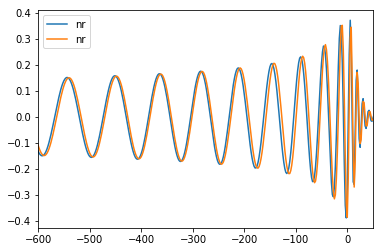

In [608]:
plt.figure()
plt.plot(nrdata[0].times, nrdata[0].hlm.real, label='nr')
plt.plot(nrdata[0].times, np.real(eta_scale*nn_amp * np.exp(-1.j * (nn_phi + phi_scale))), label='nr')
plt.legend()
# plt.xlim(-1000,50)
plt.xlim(-600,50);
# plt.show()

### minimise over a phase shift

In [609]:
from scipy.interpolate import interp1d

In [610]:
nrphase_int = interp1d(nrdata[0].times, nrdata[0].phi)
modelphase_int = interp1d(nrdata[0].times, (nn_phi[:,0] + phi_scale))
shift = nrphase_int(-200)-modelphase_int(-200)

In [611]:
nrphase_int(-200)

array(-321.56994155)

In [612]:
modelphase_int(-200)

array(-321.22158129)

In [613]:
shift = nrphase_int(-200)-modelphase_int(-200)

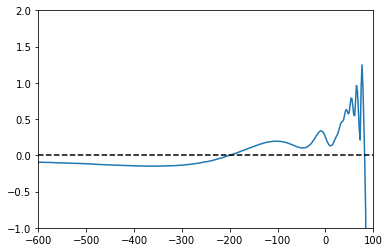

In [614]:
plt.plot(nrdata[0].times, (nn_phi[:,0] + phi_scale + shift)-nrdata[0].phi)
plt.axhline(0, ls='--',color='black')
plt.xlim(-600,100);
plt.ylim(-1,2);

### try computing the match

In [615]:
import pycbc
from pycbc.types import TimeSeries, FrequencySeries
from pycbc import waveform
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match, matched_filter

In [616]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [617]:
# construct pycbc TimeSeries objects
print("need to convert dimensionless M into seconds")
mtot=100
dt=nrdata[0].times[1]-nrdata[0].times[0]
dt_seconds = phenom.MtoS(dt, mtot)
nr_ts = TimeSeries(nrdata[0].hlm.real, delta_t=dt_seconds, epoch=0., dtype=np.double)
nn_ts = TimeSeries(np.real(eta_scale*nn_amp * np.exp(-1.j * (nn_phi + phi_scale))), delta_t=dt_seconds, epoch=0., dtype=np.double)


need to convert dimensionless M into seconds


In [618]:
int_nr_phase = InterpolatedUnivariateSpline(nrdata[0].times, nrdata[0].phi, k=4)

In [619]:
int_nr_phase_deriv = int_nr_phase.derivative()

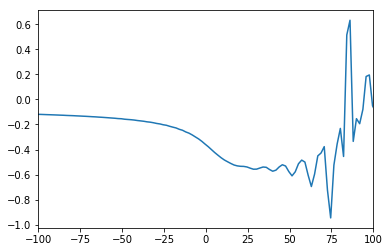

In [620]:
# plt.plot(nrdata[0].times, nrdata[0].phi, 'o')
plt.plot(nrdata[0].times, int_nr_phase_deriv(nrdata[0].times))
# plt.plot(nrdata[0].times, int_nr_phase(nrdata[0].times))
plt.xlim(-100,100);

In [621]:
int_nr_phase = InterpolatedUnivariateSpline(phenom.MtoS(nrdata[0].times, mtot), nrdata[0].phi, k=5)

In [622]:
int_nr_phase_deriv = int_nr_phase.derivative()

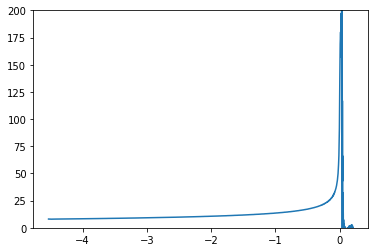

In [623]:
plt.plot(phenom.MtoS(nrdata[0].times, mtot), -int_nr_phase_deriv(phenom.MtoS(nrdata[0].times, mtot))/2/np.pi)
plt.ylim(0,200);

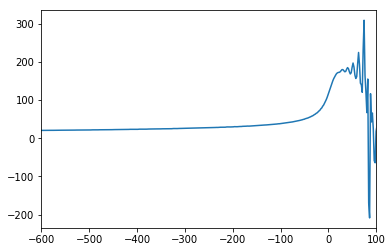

In [624]:
plt.plot(nrdata[0].times, -int_nr_phase_deriv(phenom.MtoS(nrdata[0].times, mtot))/2/np.pi)
plt.xlim(-600,100);
# plt.ylim(0,30)
# plt.ylim(100,200)

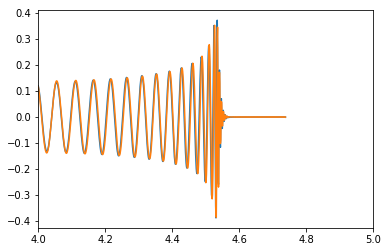

In [625]:
plt.plot(nr_ts.sample_times, nr_ts.data[:])
plt.plot(nr_ts.sample_times, nn_ts.data[:])
plt.xlim(4, 5);

In [626]:
# ensure that both signal and template have the same length
tlen = max(len(nr_ts), len(nn_ts))
nr_ts.resize(tlen)
nn_ts.resize(tlen)

In [627]:
# Generate the aLIGO ZDHP PSD
f_lower=10
delta_f = 1.0 / nr_ts.duration
flen = tlen/2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
# psd=None

In [628]:
nr_ts.duration

4.738711920307664

In [629]:
# m, i = match(nr_ts, nn_ts, psd=psd, low_frequency_cutoff=f_lower)
m, i = match(nn_ts, nr_ts, psd=psd, low_frequency_cutoff=35, high_frequency_cutoff=180)
print(m)

0.9972549850560393


In [630]:
# compute match as a function of low frequency cutoff

In [631]:
flist = range(10, 60, 2)
m_list = np.zeros(len(flist))
for i,f in enumerate(flist):
    m_list[i], _ = match(nn_ts, nr_ts, psd=psd, low_frequency_cutoff=f, high_frequency_cutoff=180)


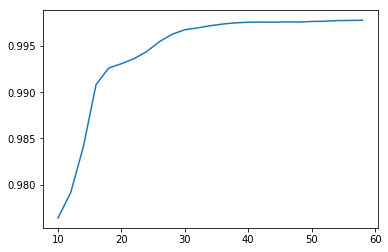

In [632]:
plt.figure()
# plt.scatter(flist, m_list)
plt.plot(flist, m_list)

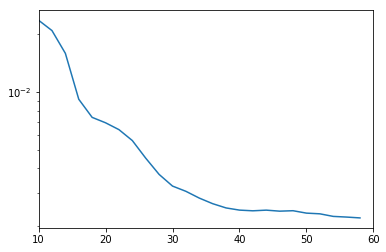

In [633]:
plt.figure()
# plt.scatter(flist, m_list)
plt.plot(flist, 1-m_list)
plt.yscale('log')
plt.xlim(10,60);

### plot model and data

In [634]:
def plot_model_and_nr(idx, nrdata, amp_nn, phi_nn):
    nn_amp, nn_phi = predict_h22(loaded_model_amp, loaded_model_phi, nrdata[idx].q, nrdata[idx].times)
    phi_scale = nrdata[idx].phi[-1]
    eta_scale = nrdata[idx].eta
    
    nrphase_int = interp1d(nrdata[idx].times, nrdata[idx].phi)
    modelphase_int = interp1d(nrdata[idx].times, (nn_phi[:,0] + phi_scale))
    shift = nrphase_int(-200)-modelphase_int(-200)
    
    
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    axes[0].set_title('mass-ratio = {0}'.format(nrdata[idx].q))
    axes[0].plot(nrdata[idx].times, nrdata[idx].hlm.real, label='nr')
    axes[0].plot(nrdata[idx].times, np.real(eta_scale*nn_amp * np.exp(-1.j *  (nn_phi + phi_scale+shift))), label='model')
    axes[0].plot(nrdata[idx].times, eta_scale*nn_amp, label='amp-model')
    
    axes[0].set_xlim(-800,50)
    axes[0].axvline(-600, color='black', ls='--')
#     axes[0].set_xlim(-1000,50)
    axes[0].legend()
    
    axes[1].plot(nrdata[idx].times, nrdata[idx].hlm.real)
    axes[1].plot(nrdata[idx].times, np.real(eta_scale*nn_amp * np.exp(-1.j * (nn_phi + phi_scale+shift))))
    axes[1].plot(nrdata[idx].times, eta_scale*nn_amp, label='amp-model')
    axes[1].set_xlim(-100,50)
    # plt.show()

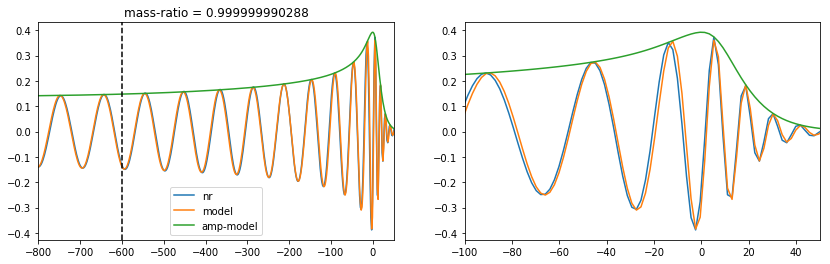

In [635]:
plot_model_and_nr(0, nrdata, loaded_model_amp, loaded_model_phi)

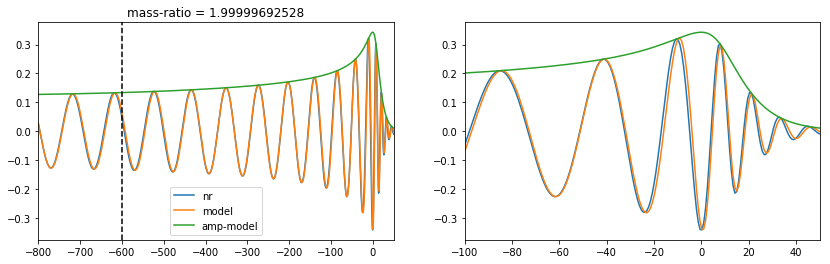

In [636]:
plot_model_and_nr(1, nrdata, loaded_model_amp, loaded_model_phi)

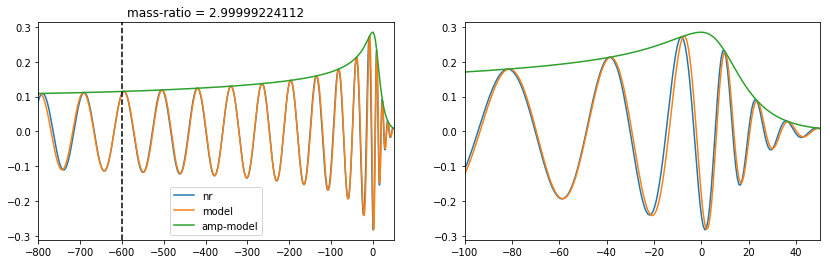

In [637]:
plot_model_and_nr(2, nrdata, loaded_model_amp, loaded_model_phi)

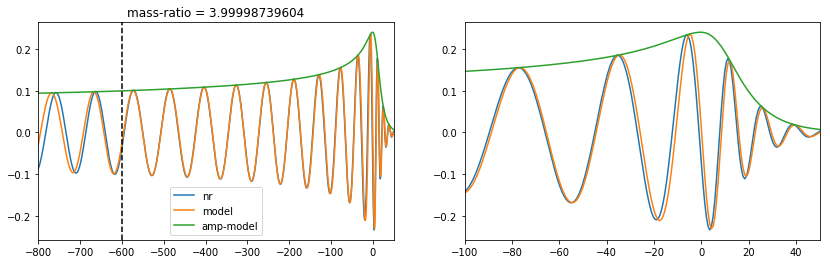

In [638]:
plot_model_and_nr(3, nrdata, loaded_model_amp, loaded_model_phi)

### testing set

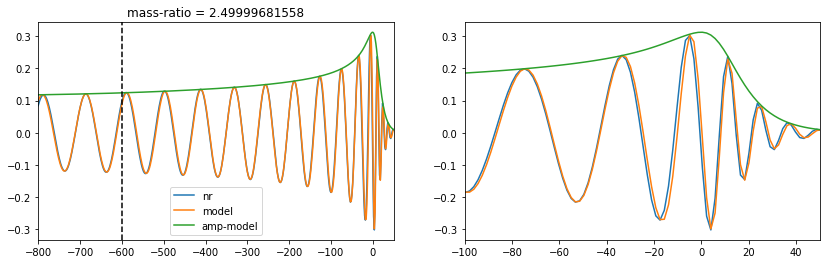

In [639]:
plot_model_and_nr(4, nrdata, loaded_model_amp, loaded_model_phi)

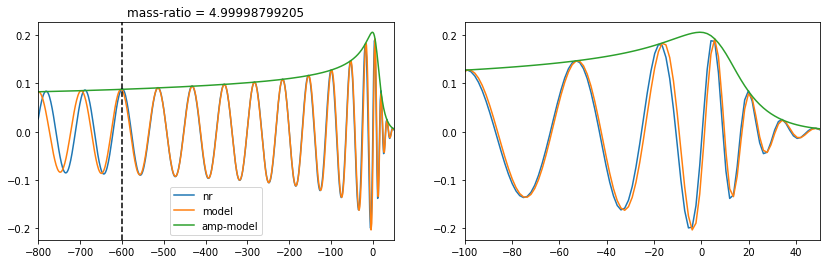

In [640]:
plot_model_and_nr(5, nrdata, loaded_model_amp, loaded_model_phi)

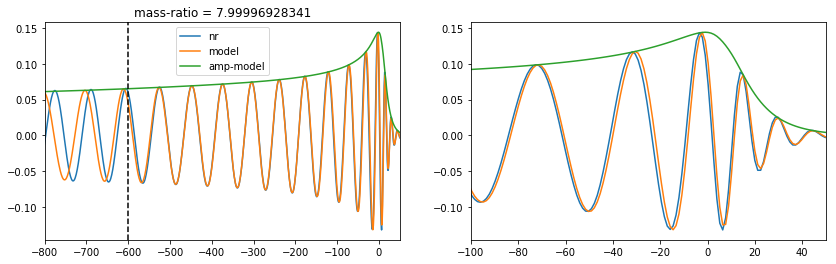

In [641]:
plot_model_and_nr(6, nrdata, loaded_model_amp, loaded_model_phi)

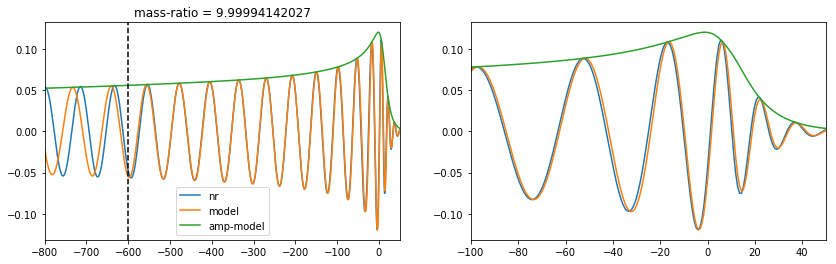

In [642]:
plot_model_and_nr(7, nrdata, loaded_model_amp, loaded_model_phi)